In [93]:
### PYMOO
from pymoo.core.problem import Problem, ElementwiseProblem, StarmapParallelization
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.util.display.multi import MultiObjectiveOutput
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation
from pymoo.indicators.hv import HV
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.termination import get_termination

#multiprocessamento e outros
from tqdm.notebook import trange, tqdm
import multiprocessing, requests, sys, time, itertools, dill, random, os, pickle, copy

#Pandas, SKLearn e etc.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score

#Goatools e Gontosim
from goatools.obo_parser import GODag
from goatools.base import get_godag
#go = get_godag("go-basic.obo", optional_attrs={'relationship'})
from Similarity import Similarity_of_Two_GOTerms, Similarity_of_Set_of_GOTerms
from sklearn.ensemble import RandomForestClassifier

'''Constantes'''
MAX_FEATURES = 100

In [6]:
data = pd.read_pickle('Data/data_Breast_GSE70947_norm.pkl')
colunas = data.columns.drop(['type']).tolist()

affymetrix_similarity = pd.read_pickle('./Data/Breast_GSE70947-gene_symbols.pkl')
go_completeness = dict(zip(affymetrix_similarity['feature'], affymetrix_similarity['scores']))
go_completeness_breast_cancer = dict(zip(affymetrix_similarity['feature'], affymetrix_similarity['scores_breast_cancer_pathways']))
del go_completeness['type']
del go_completeness_breast_cancer['type']
X = data[colunas]
y = data['type']

array([0., 0., 0., ..., 0., 0., 0.])

In [141]:
for i in go_completeness.keys():
    if go_completeness[i] != 1:
       go_completeness[i] = 0.0

for i in go_completeness_breast_cancer.keys():
    if go_completeness_breast_cancer[i] != 1:
       go_completeness_breast_cancer[i] = 0.0

go_completeness = np.array(list(go_completeness.values()))

### Função de avaliação

In [8]:
class GeneSelection(ElementwiseProblem):
    def __init__(self, X, y, runner):
        self.n_features = X.shape[1]
        self.eval_dict = {'n_features':[], 'f1_score':[]}
        super().__init__(   n_var=self.n_features,
    						n_obj=2,
    						n_constr=0,
    						xl=np.zeros(self.n_features),
    						xu=np.ones(self.n_features),
    						elementwise_evaluation=True,
                            type_var=bool,
                            save_history=True,
                            elementwise_runner=runner)

    def _evaluate(self, x, out, *args, **kwargs):
        selected_features = np.where(x == 1)[-1] # seleciona as features de acordo com o vetor binário
        X_selected = X_worker[:,selected_features]
        f_1 = []
        n_tests = 5
        seed = 41
        for i in range(n_tests):
            seed = seed + 1
            skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True) # Kfolding usado para separar em treino e teste
            clf = svm.SVC(kernel='linear') # treino usando modelo SVM
            f_1.append(np.mean(cross_val_score(clf, X_selected, y_worker, cv=skf, scoring='f1_macro'))) # Computar f1
        
        f_1 = round(np.array(f_1).sum()/n_tests, 3)
        n_features = len(selected_features)
        # salvar os resultados
        self.eval_dict['n_features'].append(n_features)
        self.eval_dict['f1_score'].append(f_1)
        out["F"] = [n_features, -f_1] # define os objetivos a serem minimizados

### Sampling

In [96]:
class BinaryDistributedWeightsSampling(Sampling):
    def __init__(self, **kwargs):
        self.sampling_weights = kwargs.pop('sampling_weights', None)
        self.seed = kwargs.pop('seed', 42)
        super().__init__(**kwargs)
        
    def _do(self, problem, n_samples, **kwargs):
        random.seed(self.seed)
        population = []
        for i in range(n_samples):
            trues = np.random.randint(1, MAX_FEATURES + 1)
            individual = np.full(len(colunas), False)
            individual[random.choices(range(len(colunas)), weights = self.sampling_weights, k=trues)] = True
            population.append(individual)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        print(sorted(row_sums))
        return population


### Mutation

In [149]:
class BitflipMutationLimitedBalanced(Mutation):
    def __init__(self, **kwargs):
        self.weights = kwargs.pop('weights', None)
        super().__init__(**kwargs)
        
    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        full = np.random.rand(*X.shape) < prob_var  # Evita uma criação redundante de matriz e faz o flip diretamente

        # Itera diretamente em X e full para alterar os valores
        for individual, vector in zip(X, full):
            num_changes = min(MAX_FEATURES, np.sum(vector))  # Limita a quantidade de alterações pelo MAX_FEATURES
            true_indices = np.where(individual)[0]
            false_indices = np.where(~individual)[0]
        
            # Seleciona índices aleatórios para trocar, dividindo o número de mudanças igualmente entre 'True' e 'False'
            flip_choices = np.random.rand(num_changes) < 0.5
            true_flips = np.sum(flip_choices)
            false_flips = num_changes - true_flips

            if self.weights is not None:
                weights = self.weights[false_indices]
            else:
                weights = None
            
            if true_flips > 0 and len(true_indices) > 0:
                individual[np.random.choice(true_indices, min(true_flips, len(true_indices)), replace=False)] = False
            if false_flips > 0 and len(false_indices) > 0:
                individual[random.choices(false_indices, k = min(false_flips, len(false_indices)), weights=weights)] = True

        for individual in X:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual = individual[np.random.choice(np.where(individual == True)[0], MAX_FEATURES)]
        return X

### Init Workers

In [41]:
def _init_evaluator():
    global pid_, X_worker, y_worker, colunas_worker
    pid_ = os.getpid()
    X_worker = np.array(X.copy())
    y_worker = np.array(y.copy())
    colunas_worker = colunas.copy()

### Inicializar a Pool e criar os runners

In [42]:
try:
    pool.close()
    _pool.close()
except:
    pass
n_proccess = 48
pool = multiprocessing.Pool(n_proccess, initializer=_init_evaluator)
runner = StarmapParallelization(pool.starmap)

### Definição do problema

In [49]:
problem = GeneSelection(X,y.values, runner)
algorithm = NSGA2(pop_size=100,
				  sampling=BinaryDistributedWeightsSampling(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutationLimitedBalanced(weights = np.array(list(go_completeness.values()))),
                  #display = MultiObjectiveOutputCustom(),
                  save_history = True)

### Roda 1 instância

In [50]:
start = time.time()
res = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 10), # number of iteration for eval problem class
			    verbose=True)
print(time.time() - start)
plotSingleResult(res)

[2, 3, 4, 4, 4, 5, 6, 6, 7, 7, 7, 8, 9, 10, 12, 12, 13, 15, 15, 15, 15, 15, 16, 17, 20, 21, 23, 25, 27, 27, 27, 27, 32, 33, 33, 34, 34, 34, 35, 35, 36, 37, 37, 37, 41, 43, 44, 47, 48, 50, 51, 53, 54, 55, 55, 56, 57, 57, 58, 58, 59, 60, 60, 61, 62, 64, 66, 67, 68, 69, 69, 71, 74, 77, 78, 79, 80, 82, 82, 83, 85, 85, 85, 88, 88, 88, 91, 91, 92, 93, 93, 94, 94, 96, 96, 96, 97, 97, 98, 99]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      7 |             - |             -
     2 |      200 |      8 |  0.0929368030 |         ideal
     3 |      300 |      8 |  0.0555068868 |             f
     4 |      400 |     11 |  0.0659722222 |         ideal
     5 |      500 |      7 |  0.0355555556 |         ideal
     6 |      600 |      8 |  0.5734265734 |         nadir
     7 |      700 |     12 |  0.0368186989 |             f
     8 |      800 |     12 |  0.0345793836 |             f
     9 |      900 |     11 |  0.4158415842 |         nadir
    10 |     1000 |   

NameError: name 'plotSingleResult' is not defined

In [150]:
class Experiment():
    def __init__(self, **kwargs):
        self.problem = kwargs.get('problem', None)
        self.n_population = kwargs.get('n_population', None)
        self.n_gen = kwargs.get('n_gen', None)
        self.sampling = kwargs.get('sampling', None)
        self.seed = kwargs.get('seed', None)
        self.mutation = kwargs.get('mutation', None)
        self.weights = kwargs.get('weights', None)
        self.max_features = kwargs.get('max_features', 100)
        self.algorithm = NSGA2(pop_size = self.n_population,
                		  sampling = self.sampling,
                		  crossover = TwoPointCrossover(),
                		  mutation = self.mutation,
                          save_history = True)
    def run_experiment(self):
        self.result = minimize(self.problem,  # problem class
			      self.algorithm,  # NSGA2 algorithm
                  ("n_gen", self.n_gen), # number of iteration for eval problem class
			      verbose=True)

    def plot_result(self):
        n_evals = np.array([e.evaluator.n_eval for e in self.result.history])
        opt = np.array([e.opt[0].F for e in self.result.history])
        X_res, F_res = self.result.opt.get("X", "F")
            
        hist = self.result.history
        max = 100
        ref_point = np.array([15, -0.75])
        ind = HV(ref_point=ref_point)
            
        n_evals = []             # corresponding number of function evaluations\
        hist_F = []              # the objective space values in each generation
        hist_cv = []             # constraint violation in each generation
        hist_cv_avg = []         # average constraint violation in the whole population
            
        for algo in hist:
            # store the number of function evaluations
            n_evals.append(algo.evaluator.n_eval)
            
            # retrieve the optimum from the algorithm
            opt = algo.opt
            
            # store the least contraint violation and the average in each population
            hist_cv.append(opt.get("CV").min())
            hist_cv_avg.append(algo.pop.get("CV").mean())
            
            # filter out only the feasible and append and objective space values
            feas = np.where(opt.get("feasible"))[0]
            hist_F.append(opt.get("F")[feas])
        
        metric = HV(ref_point= ref_point,
                                 norm_ref_point=False)
        
        hv = [metric.do(_F)/max for _F in hist_F]
        
            #plt.figure(figsize=(7, 5))
        plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
        plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
        plt.title("Convergence")
        plt.xlabel("Function Evaluations")
        plt.ylabel("Hypervolume")
        return hv[-1]

    def plot_pareto_front(self, **kwargs):
        #plt.figure(figsize=(7, 5))
        color = kwargs.get('color', 'blue')
        X_res, F_res = self.result.opt.get("X", "F")
        plt.plot(F_res[:, 0][np.argsort(F_res[:, 1])], F_res[:, 1][np.argsort(F_res[:, 1])], color = color,  marker='o', mfc=color, mec=color, ms=2, ls='--', lw=0.5, zorder=2)
        plt.title("Objective Space")
            

[1, 1, 2, 3, 3, 6, 6, 6, 7, 9, 10, 12, 13, 15, 15, 15, 16, 17, 21, 23, 23, 23, 24, 24, 24, 25, 26, 27, 29, 31, 31, 31, 33, 34, 34, 34, 35, 37, 39, 39, 40, 41, 41, 41, 41, 43, 43, 45, 48, 50, 50, 50, 51, 53, 54, 54, 55, 56, 56, 59, 59, 60, 60, 63, 63, 64, 64, 68, 68, 71, 72, 75, 75, 78, 78, 79, 80, 80, 81, 81, 82, 84, 84, 85, 86, 86, 86, 88, 91, 91, 92, 93, 95, 95, 95, 96, 97, 98, 99, 99]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      6 |             - |             -
     2 |      200 |      5 |  0.0210526316 |         ideal
     3 |      300 |      5 |  0.0965517241 |         ideal
     4 |      400 |      7 |  0.0109890110 |         ideal
     5 |      500 |      9 |  0.0520833333 |         ideal
     6 |      600 |     13 |  0.0495049505 |         ideal
     7 |      700 |     12 |  0.0476190476 |         nadir
     8 |      800 |      8 |  0.0196078431 |         ideal
     9 |      900 |     10 |  0.0192307692 |         ideal
    10 |     1000 |

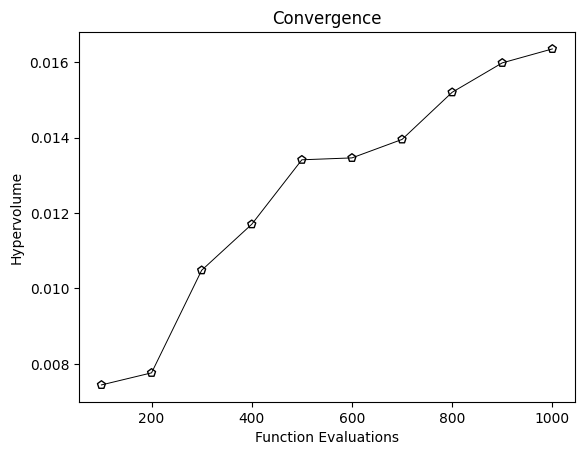

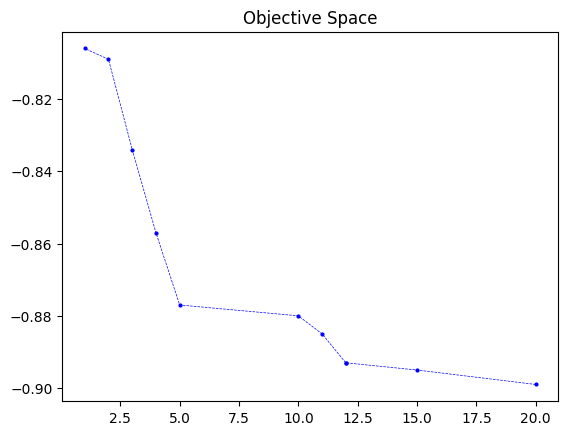

In [145]:
normal = Experiment(problem = problem, n_population = 100, n_gen = 10, sampling = BinaryDistributedWeightsSampling(seed = 40), seed = 42,
           mutation = BitflipMutationLimitedBalanced(weights = go_completeness), weights = go_completeness, max_features = 100)

normal.run_experiment()
normal.plot_result()
plt.show()
normal.plot_pareto_front() 

In [151]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X, y)

svm_init = Experiment(problem = problem, n_population = 100, n_gen = 10, sampling = BinaryDistributedWeightsSampling(sampling_weights = clf.feature_importances_, seed = 40), seed = 42,
           mutation = BitflipMutationLimitedBalanced(), weights = None, max_features = 100)

[1, 1, 2, 4, 5, 8, 11, 11, 11, 12, 13, 15, 15, 16, 17, 18, 18, 19, 19, 21, 22, 23, 23, 23, 24, 25, 28, 29, 31, 35, 36, 37, 38, 40, 41, 41, 42, 42, 43, 43, 44, 45, 45, 46, 49, 49, 51, 53, 54, 54, 55, 55, 56, 56, 56, 56, 58, 58, 58, 59, 62, 63, 63, 65, 65, 66, 66, 66, 67, 67, 67, 68, 69, 70, 71, 73, 76, 77, 77, 77, 80, 80, 80, 82, 83, 84, 84, 87, 87, 89, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     10 |             - |             -
     2 |      200 |     11 |  0.0163896785 |             f
     3 |      300 |     12 |  0.0547945205 |         ideal
     4 |      400 |      9 |  0.0135135135 |         ideal
     5 |      500 |      9 |  0.0400000000 |         ideal
     6 |      600 |      9 |  0.0079365079 |         ideal
     7 |      700 |     10 |  0.2989690722 |         nadir
     8 |      800 |      8 |  0.0582524272 |         ideal
     9 |      900 |      8 |  0.0294757197 |             f
    10 |     10

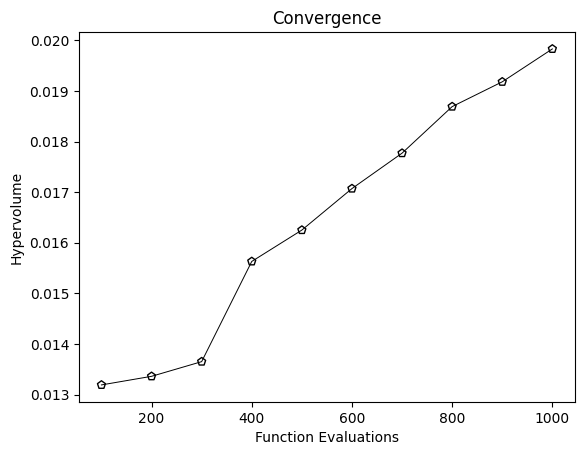

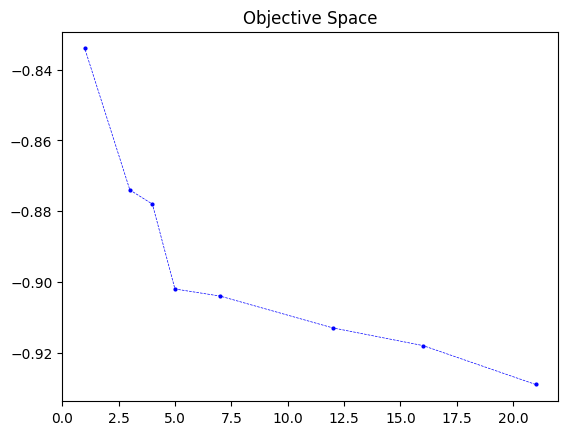

In [152]:
svm_init.run_experiment()
svm_init.plot_result()
plt.show()
svm_init.plot_pareto_front()

In [153]:
svm_inits = []
svm_init_weights = []
stocks = []
stock_weights = []
for i in tqdm(range(5)):
    experiment = Experiment(problem = problem, n_population = 200, n_gen = 100, sampling = BinaryDistributedWeightsSampling(sampling_weights = clf.feature_importances_, seed = 40), seed = 42,
           mutation = BitflipMutationLimitedBalanced(weights = None), weights = None, max_features = 100)
    experiment.run_experiment()
    svm_inits.append(experiment)

    experiment = Experiment(problem = problem, n_population = 200, n_gen = 100, sampling = BinaryDistributedWeightsSampling(sampling_weights = clf.feature_importances_, seed = 40), seed = 42,
           mutation = BitflipMutationLimitedBalanced(weights = go_completeness), weights = None, max_features = 100)
    experiment.run_experiment()
    svm_init_weights.append(experiment)

    experiment = Experiment(problem = problem, n_population = 200, n_gen = 100, sampling = BinaryDistributedWeightsSampling(seed = 40), seed = 42,
           mutation = BitflipMutationLimitedBalanced(weights = None), weights = None, max_features = 100)
    experiment.run_experiment()
    stocks.append(experiment)

    experiment = Experiment(problem = problem, n_population = 200, n_gen = 100, sampling = BinaryDistributedWeightsSampling(seed = 40), seed = 42,
           mutation = BitflipMutationLimitedBalanced(weights = go_completeness), weights = None, max_features = 100)
    experiment.run_experiment()
    stocks.append(experiment)

  0%|          | 0/5 [00:00<?, ?it/s]

[1, 1, 2, 2, 2, 3, 3, 5, 5, 5, 6, 7, 7, 8, 8, 9, 9, 10, 10, 10, 10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 15, 15, 15, 15, 16, 17, 18, 19, 19, 20, 20, 20, 20, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 26, 26, 26, 27, 27, 28, 28, 32, 33, 33, 34, 35, 36, 36, 36, 37, 37, 37, 37, 37, 38, 39, 39, 41, 41, 41, 41, 41, 41, 42, 42, 43, 44, 45, 45, 46, 46, 47, 47, 47, 47, 48, 49, 51, 51, 52, 53, 53, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 58, 59, 59, 60, 61, 61, 62, 63, 63, 64, 65, 66, 66, 66, 67, 67, 67, 68, 68, 68, 68, 69, 69, 69, 69, 70, 70, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 75, 76, 76, 77, 77, 78, 79, 79, 79, 79, 80, 81, 82, 82, 82, 85, 85, 85, 87, 87, 88, 89, 89, 90, 90, 90, 90, 91, 92, 92, 93, 93, 93, 93, 93, 94, 95, 95, 96, 97, 98]
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      6 |             - |             -
     2 |      400 |      5 |  0.0653170883 |             f
     3 |      600 |      8 |  0.0932642

In [1]:
for experiment in stocks:
    experiment.plot_pareto_front(color = 'red')
for experiment in svm_inits:
    experiment.plot_pareto_front()
for experiment in stock_weights:
    experiment.plot_pareto_front(color = 'black')
for experiment in svm_init_weights:
    experiment.plot_pareto_front(color = 'yellow')

plt.show()
for experiment in stocks:
    experiment.plot_result()
for experiment in svm_inits:
    experiment.plot_result()


NameError: name 'stocks' is not defined

In [124]:
def plot_convergence(res, color):
    n_evals = np.array([e.evaluator.n_eval for e in res.history])
    opt = np.array([e.opt[0].F for e in res.history])
    
    X_res, F_res = res.opt.get("X", "F")
    
    hist = res.history
    max = 15
    ref_point = np.array([max, -0.75])
    ind = HV(ref_point=ref_point)
    
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    
    for algo in hist:
        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)
    
        # retrieve the optimum from the algorithm
        opt = algo.opt
    
        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())
    
        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
    
    metric = HV(ref_point= ref_point,
                         norm_ref_point=True)

    hv = [metric.do(_F)/5 for _F in hist_F]

    plt.plot(n_evals, hv,  color='black', lw=0.3, label="Avg. CV of Pop", alpha = 1)
    plt.scatter(n_evals, hv,  facecolor="none", edgecolor=color, marker="p", linewidths=0.5, alpha = 1)
    plt.title("Convergence")
    plt.xlabel("Function Evaluations")
    plt.ylabel("Hypervolume")
    #for i in range(20):
    #    plt.axvline(x=200*i, color='r', linestyle='--', linewidth=0.7)
    #plt.xscale(value = 'log')
    #plt.show()
    return ind(F_res)/5

In [2]:
plt.figure(figsize=(16,6))

for experiment in stocks:
    plot_convergence(experiment.result, 'blue')

for experiment in svm_inits:
    plot_convergence(experiment.result, 'red')
for experiment in svm_init_weights:
    plot_convergence(experiment.result, 'yellow')

NameError: name 'plt' is not defined

In [134]:
def calculate_mean_std(results):
    max = 15
    ref_point = np.array([25, -0.75])
    metric = HV(ref_point= ref_point, norm_ref_point=False)
    hypervolumes = []
    for result in results:
        hypervolumes.append(metric.do(result.result.opt.get("F"))/5)
    print("Mean: ",np.array(hypervolumes).mean())
    print("STD: ",np.array(hypervolumes).std())



In [160]:
calculate_mean_std(stocks)
calculate_mean_std(svm_inits)
calculate_mean_std(svm_init_weights)

Mean:  0.92052
STD:  0.029288113629935258
Mean:  0.9691199999999999
STD:  0.011806845472013324
Mean:  0.9648
STD:  0.01672698418723476
